In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
seed = 1993

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import io
import xgboost as xgb
import lightgbm as lgbm
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import preprocessing as pre

import random
random.seed(seed)
np.random.seed(seed)

import sys
sys.path.append('/kaggle/input/iterativestratification/')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/iterativestratification/.travis.yml
/kaggle/input/iterativestratification/setup.cfg
/kaggle/input/iterativestratification/LICENSE
/kaggle/input/iterativestratification/.gitignore
/kaggle/input/iterativestratification/README.md
/kaggle/input/iterativestratification/setup.py
/kaggle/input/iterativestratification/tests/test_ml_stratifiers.py
/kaggle/input/iterativestratification/tests/__init__.py
/kaggle/input/iterativestratification/iterstrat/ml_stratifiers.py
/kaggle/input/iterativestratification/iterstrat/__init__.py
/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


In [2]:
class config():
    
    MAIN_PATH = '/kaggle/input/icr-identify-age-related-conditions/'
    FOLDS = 5
    do_TEST = True
    train_split = 0.9
    eliminar_features = True
    features_a_eliminar = ['DV', 'EJ'] # de feature importances
    do_grid= False
    do_PCA = False
    PCA_components = 45
    normalize = False
    downsample = False
    ensemble = 'weigths' # weigths, media
    
    def competition_log_loss(y_true, y_pred):
        # y_true: correct labels 0, 1
        # y_pred: predicted probabilities of class=1
        # Implements the Evaluation equation with w_0 = w_1 = 1.
        # Calculate the number of observations for each class
        N_0 = np.sum(1 - y_true)
        N_1 = np.sum(y_true)
        # Calculate the predicted probabilities for each class
        p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
        p_0 = 1 - p_1
        # Calculate the average log loss for each class
        log_loss_0 = -np.sum((1 - y_true) * np.log(p_0)) / N_0
        log_loss_1 = -np.sum(y_true * np.log(p_1)) / N_1
        # return the (not further weighted) average of the averages
        return (log_loss_0 + log_loss_1)/2
    

    def balance_logloss(y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
        y_pred / np.sum(y_pred, axis=1)[:, None]
        nc = np.bincount(y_true)
        w0, w1 = 1/(nc[0]/y_true.shape[0]), 1/(nc[1]/y_true.shape[0])

        logloss = (-w0/nc[0]*(np.sum(np.where(y_true==0,1,0) * np.log(y_pred[:,0]))) - w1/nc[1]*(np.sum(np.where(y_true!=0,1,0) * np.log(y_pred[:,1])))) / (w0+w1)

        return logloss
    # https://www.kaggle.com/code/chaitanyagiri/icr-2023-single-lgbm-0-12-cv-0-16-lb/comments
    def balanced_log_loss(y_true, y_pred):
        N_0 = np.sum(1 - y_true)
        N_1 = np.sum(y_true)
        p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
        p_0 = 1 - p_1
        log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
        log_loss_1 = -np.sum(y_true * np.log(p_1))
        w_0 = 1 / N_0
        w_1 = 1 / N_1
        balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
        return balanced_log_loss/(N_0+N_1)

In [3]:
df_train = pd.read_csv(config.MAIN_PATH + 'train.csv')
df_summit = pd.read_csv(config.MAIN_PATH + 'test.csv')
df_greeks = pd.read_csv(config.MAIN_PATH + 'greeks.csv')
sample_submission = pd.read_csv(config.MAIN_PATH + 'sample_submission.csv')

print(df_train.shape)
print(df_summit.shape)
print(df_greeks.shape)
print(sample_submission.shape)

(617, 58)
(5, 57)
(617, 6)
(5, 3)


In [4]:
df_train.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


In [5]:
from datetime import datetime
times = df_greeks.Epsilon.copy()
times[df_greeks.Epsilon != 'Unknown'] = df_greeks.Epsilon[df_greeks.Epsilon != 'Unknown'].map(lambda x: datetime.strptime(x,'%m/%d/%Y').toordinal())
times[df_greeks.Epsilon == 'Unknown'] = np.nan
times

0      737137.0
1           NaN
2           NaN
3           NaN
4      737509.0
         ...   
612    737681.0
613    737676.0
614    737264.0
615    737090.0
616         NaN
Name: Epsilon, Length: 617, dtype: object

In [6]:
df = pd.merge(df_train, df_greeks, on='Id', how = 'left')
df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,2003.810319,22.136229,69.834944,0.120343,1,B,C,G,D,3/19/2019
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,27981.562750,29.135430,32.131996,21.978000,0,A,C,M,B,Unknown
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,13676.957810,28.022851,35.192676,0.196941,0,A,C,M,B,Unknown
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,2094.262452,39.948656,90.493248,0.155829,0,A,C,M,B,Unknown
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8524.370502,45.381316,36.262628,0.096614,1,D,B,F,B,3/25/2020


In [7]:
# import warnings
# warnings.filterwarnings('ignore')

# columnas_seleccionadas = list(df_train.columns[:10]) + [df_train.columns[-1]]
# #scatterplot
# sns.set()
# cols = df_train.columns
# sns.pairplot(df_train[columnas_seleccionadas], size = 2.5, y_vars=['Class'])
# plt.show();

In [8]:
# # Compute the correlation matrix
# corr = df_train[columnas_seleccionadas].corr()

# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=bool))

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

## Un poquito de preparacion ##

In [9]:
df['EJ'] = df['EJ'].replace({'A': 0, 'B': 1})
df_summit['EJ']  = df_summit['EJ'].replace({'A': 0, 'B': 1})

In [10]:
df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,2003.810319,22.136229,69.834944,0.120343,1,B,C,G,D,3/19/2019
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,27981.562750,29.135430,32.131996,21.978000,0,A,C,M,B,Unknown
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,13676.957810,28.022851,35.192676,0.196941,0,A,C,M,B,Unknown
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,2094.262452,39.948656,90.493248,0.155829,0,A,C,M,B,Unknown
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8524.370502,45.381316,36.262628,0.096614,1,D,B,F,B,3/25/2020


In [11]:
if config.do_PCA:
    df.fillna(0, inplace = True)

In [12]:
df[df.isnull().any(axis=1)]

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon
8,0594b00fb30a,0.346113,3238.43674,85.200147,28.888816,8.138688,4.021986,0.025578,8.243016,3.626448,...,4589.611956,29.771721,54.675576,0.073416,0,A,C,M,B,2/18/2019
15,07760b4cf3f8,0.666588,3657.78160,304.283751,75.418144,8.138688,12.818973,0.025578,8.167392,1.229900,...,2218.449060,23.806958,35.843392,0.015231,0,A,C,M,B,1/29/2019
18,0b2cc0b0e6c5,0.269199,1586.67784,85.200147,14.459893,8.138688,4.907886,0.032886,7.007824,3.521028,...,3597.877440,31.330820,25.444796,0.011000,0,A,C,M,B,1/29/2019
23,0cf6c827b8bb,0.371751,2354.54142,105.030540,5.150311,8.138688,10.409325,0.025578,11.526358,2.754976,...,5987.708568,32.610844,15.019194,0.136552,0,A,C,M,B,Unknown
24,0d1b855c7635,0.158101,3257.64549,138.368592,8.640630,18.385464,4.146012,0.182700,4.099451,7.836220,...,1884.728169,48.039971,37.160256,21.978000,0,A,B,M,B,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,f12d8570682a,0.282018,4226.17426,91.392246,13.704225,8.138688,4.916745,0.025578,9.415188,1.229900,...,2118.717486,20.714807,29.786332,0.069164,0,A,C,M,B,2/18/2019
594,f46e39a96ee9,0.670861,5501.73569,93.822057,6.993026,8.138688,6.511365,0.025578,9.541228,1.229900,...,1849.552461,31.371751,10.043660,NaN,0,A,C,M,B,Unknown
602,f955c0ed8895,0.350386,5431.63797,85.200147,11.607556,8.138688,7.565586,0.025578,10.269109,2.393034,...,9146.473587,17.287766,30.712252,0.171600,0,A,C,M,B,11/27/2018
603,f96e7ca4a16c,0.662315,1704.39874,123.807144,68.353887,8.138688,5.563452,0.104139,6.736838,1.229900,...,2369.417670,19.367805,25.591400,0.130680,0,A,C,M,B,1/29/2019


In [13]:
if config.normalize:
    df.iloc[:, 1:-6] = pre.MinMaxScaler().fit_transform(df.iloc[:, 1:-6])
    print(df.head())

In [14]:
# PCA
if config.do_PCA:
    #     # Calcula la varianza explicada acumulada
    #     explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)

    #     # Encuentra el número de componentes que supera un umbral específico
    #     threshold = 0.95  # Umbral de varianza explicada acumulada
    #     n_components = np.argmax(explained_variance_ratio_cumulative >= threshold) + 1
    #     print(n_components) # da 427
    pca = PCA(n_components=config.PCA_components)
    X = pca.fit_transform(df.iloc[:, 1:-6])
    print(X.shape)
    #nuevo df
    tmp_df_id = df[['Id']].values
    tmp_df_extras = df[['Class','Alpha','Beta','Gamma','Delta','Epsilon']].values
    # columns
    columns = []
    columns.append('Id')
    for fe in pca.get_feature_names_out():
        columns.append(fe)
    columns.append('Class')
    columns.append('Alpha')
    columns.append('Beta')
    columns.append('Gamma')
    columns.append('Delta')
    columns.append('Epsilon')
    new_df = pd.DataFrame(np.concatenate((tmp_df_id, X, tmp_df_extras), axis=1), columns = columns)
    df = new_df
    # ajustamos tipos que si no lgtbm se vuelve crazy
    df[pca.get_feature_names_out()] = df[pca.get_feature_names_out()].astype('float')
    df['Class'] = df['Class'].astype('int')

In [15]:
if config.downsample:
    from imblearn.under_sampling import RandomUnderSampler
    NUM_POS = df.Class.sum()
    sampler = RandomUnderSampler(sampling_strategy={0: NUM_POS, 1: NUM_POS})
    df, _ = sampler.fit_resample(df, df['Class'])

In [16]:
#TODO TRAIN-TEST split
from sklearn.model_selection import train_test_split

if config.do_TEST:
    df_train, df_test, _,_ = train_test_split( df, df[['Class']], train_size= config.train_split, stratify = df[['Alpha']],random_state=seed)

    print(df_train.shape)
    print(df_test.shape)
    
    df_train.reset_index(inplace = True, drop=True)
    df_test.reset_index(inplace = True, drop=True)
    
else:
    df_train = df.copy()

(555, 63)
(62, 63)


## K-FOLDS ##

In [17]:
from sklearn.model_selection import StratifiedKFold
df_train['kfold'] = -1

kf = StratifiedKFold(n_splits=config.FOLDS, shuffle=True, random_state=1993)
for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=df_train, y=df_train[['Alpha']])):
    df_train.loc[valid_indicies, "kfold"] = fold

df_train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon,kfold
0,7445f4eac4de,0.542671,3203.77508,85.200147,33.363981,8.138688,5.935530,0.025578,7.070844,1.229900,...,26.653523,39.392752,0.055132,1,B,C,H,C,2/20/2019,4
1,228524bde6a3,0.346113,4088.28992,85.200147,44.401689,8.138688,4.526949,0.025578,3.396778,1.229900,...,35.077867,33.731780,0.028537,1,B,B,H,B,1/29/2020,1
2,aac8bafe74ef,0.341840,192.59328,85.200147,12.964042,8.138688,3.995409,0.025578,8.803894,1.229900,...,30.940115,7.134728,0.110928,0,A,C,M,B,4/24/2019,1
3,10187958312d,0.316202,2255.38192,85.200147,13.750680,8.138688,4.650975,0.025578,10.429810,3.535084,...,31.758735,15.007620,21.978000,0,A,C,M,B,Unknown,2
4,ac38de805eff,0.679407,5885.36377,85.200147,9.427268,8.138688,2.294481,0.025578,8.079164,1.229900,...,16.435657,14.158860,0.069015,1,B,B,H,B,6/25/2020,1


## MODEL BASELINE ##

In [18]:
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import log_loss

In [19]:
features = df_train.columns[1:-7]
label    = df_train.columns[-7]

In [20]:
if config.eliminar_features: # de una discussion en el foro
    for feature_to_del in config.features_a_eliminar:
        # Encontrar el índice del elemento a eliminar
        filas_A_eliminar = feature_to_del
        index = None
        for i, element in enumerate(features):
            if element == filas_A_eliminar:
                index = i
                break

        features = features.delete(index)
    print(features)

Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DY', 'EB', 'EE',
       'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR', 'FS',
       'GB', 'GE', 'GF', 'GH', 'GI', 'GL'],
      dtype='object')


# GRID

In [21]:
if config.do_grid:
    '''
    {'boosting_type': 'gbdt', 'colsample_bytree': 0.7,
    'learning_rate': 0.07, 'max_depth': 4, 'metric': 'binary_logloss', 'n_estimators': 10000, 'subsample': 0.7}
    '''
    # Definir los parámetros para la búsqueda de cuadrícula
    # scale_pos_weight for XG Boost model
    spw = 4.713

    param_grid = {
        'learning_rate': [0.001, 0.03, 0.07],
        'n_estimators': [1000, 7000, 10000],
        'max_depth': [3, 4, 6],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.65, 0.8],
        'boosting_type': ['gbdt'],
    #     'class_weight': 'balanced',
        'metric': ['binary_logloss'],
        'num_leaves': [10, 30, 60],
        'min_data_in_leaf': [5, 20, 50]
    #     'is_unbalance': [True]
    }

    # Inicializar el clasificador LGBM
    model = LGBMClassifier(scale_pos_weight=spw, seed = seed)

    # Realizar la búsqueda de cuadrícula
    grid_search = GridSearchCV(model, param_grid, cv=config.FOLDS,  n_jobs=-1, verbose=2)
    grid_search.fit(df_train[features], df_train[label])

    # Imprimir los mejores parámetros y puntajes
    print("Mejores parámetros encontrados:")
    print(grid_search.best_params_)
    print("Mejor puntuación de validación cruzada:")
    print(grid_search.best_score_)

# K-FOLDS

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, fold, num = 20, fig_size = (40, 20)):
    df_feature_importance = (
    pd.DataFrame({
        'Feature': model.feature_name_,
        'Value': model.feature_importances_,
    })
    .sort_values('Value', ascending=False)
    )
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=df_feature_importance.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-fold_' + str(fold)  + '.png')
#     plt.show()
    
    print('More important features')
    print(df_feature_importance.sort_values(by="Value",ascending=False)[0:num].head(6))
    print('Less important features')
    print(df_feature_importance.sort_values(by="Value",ascending=True)[0:num].head(6))

In [23]:
def lgb_metric(y_true, y_pred):
    return 'balanced_log_loss', config.competition_log_loss(y_true, y_pred), False

------------------ Fold: 0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] seed is set=1993, random_state=42 will be ignored. Current value: seed=1993
[1000]	valid_0's binary_logloss: 0.166925
TRAIN : 1.0
VAL : 0.9369369369369369
Losses en val:
logloss 0.17 y balanced 0.22
TEST : 0.9193548387096774
Losses en test:
logloss 0.21 y balanced 0.35
More important features
   Feature  Value
32      DU    449
25      DA    366
0       AB    358
12      BQ    324
53      GL    296
21      CR    284
Less important features
   Feature  Value
27      DF     15
14      BZ     23
6       AY     25
4       AR     28
2       AH     43
11      BP     61
------------------ Fold: 1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] seed is set=1993, random_state=42 will be ignored. Current value: seed=1993
[1000]	valid_0

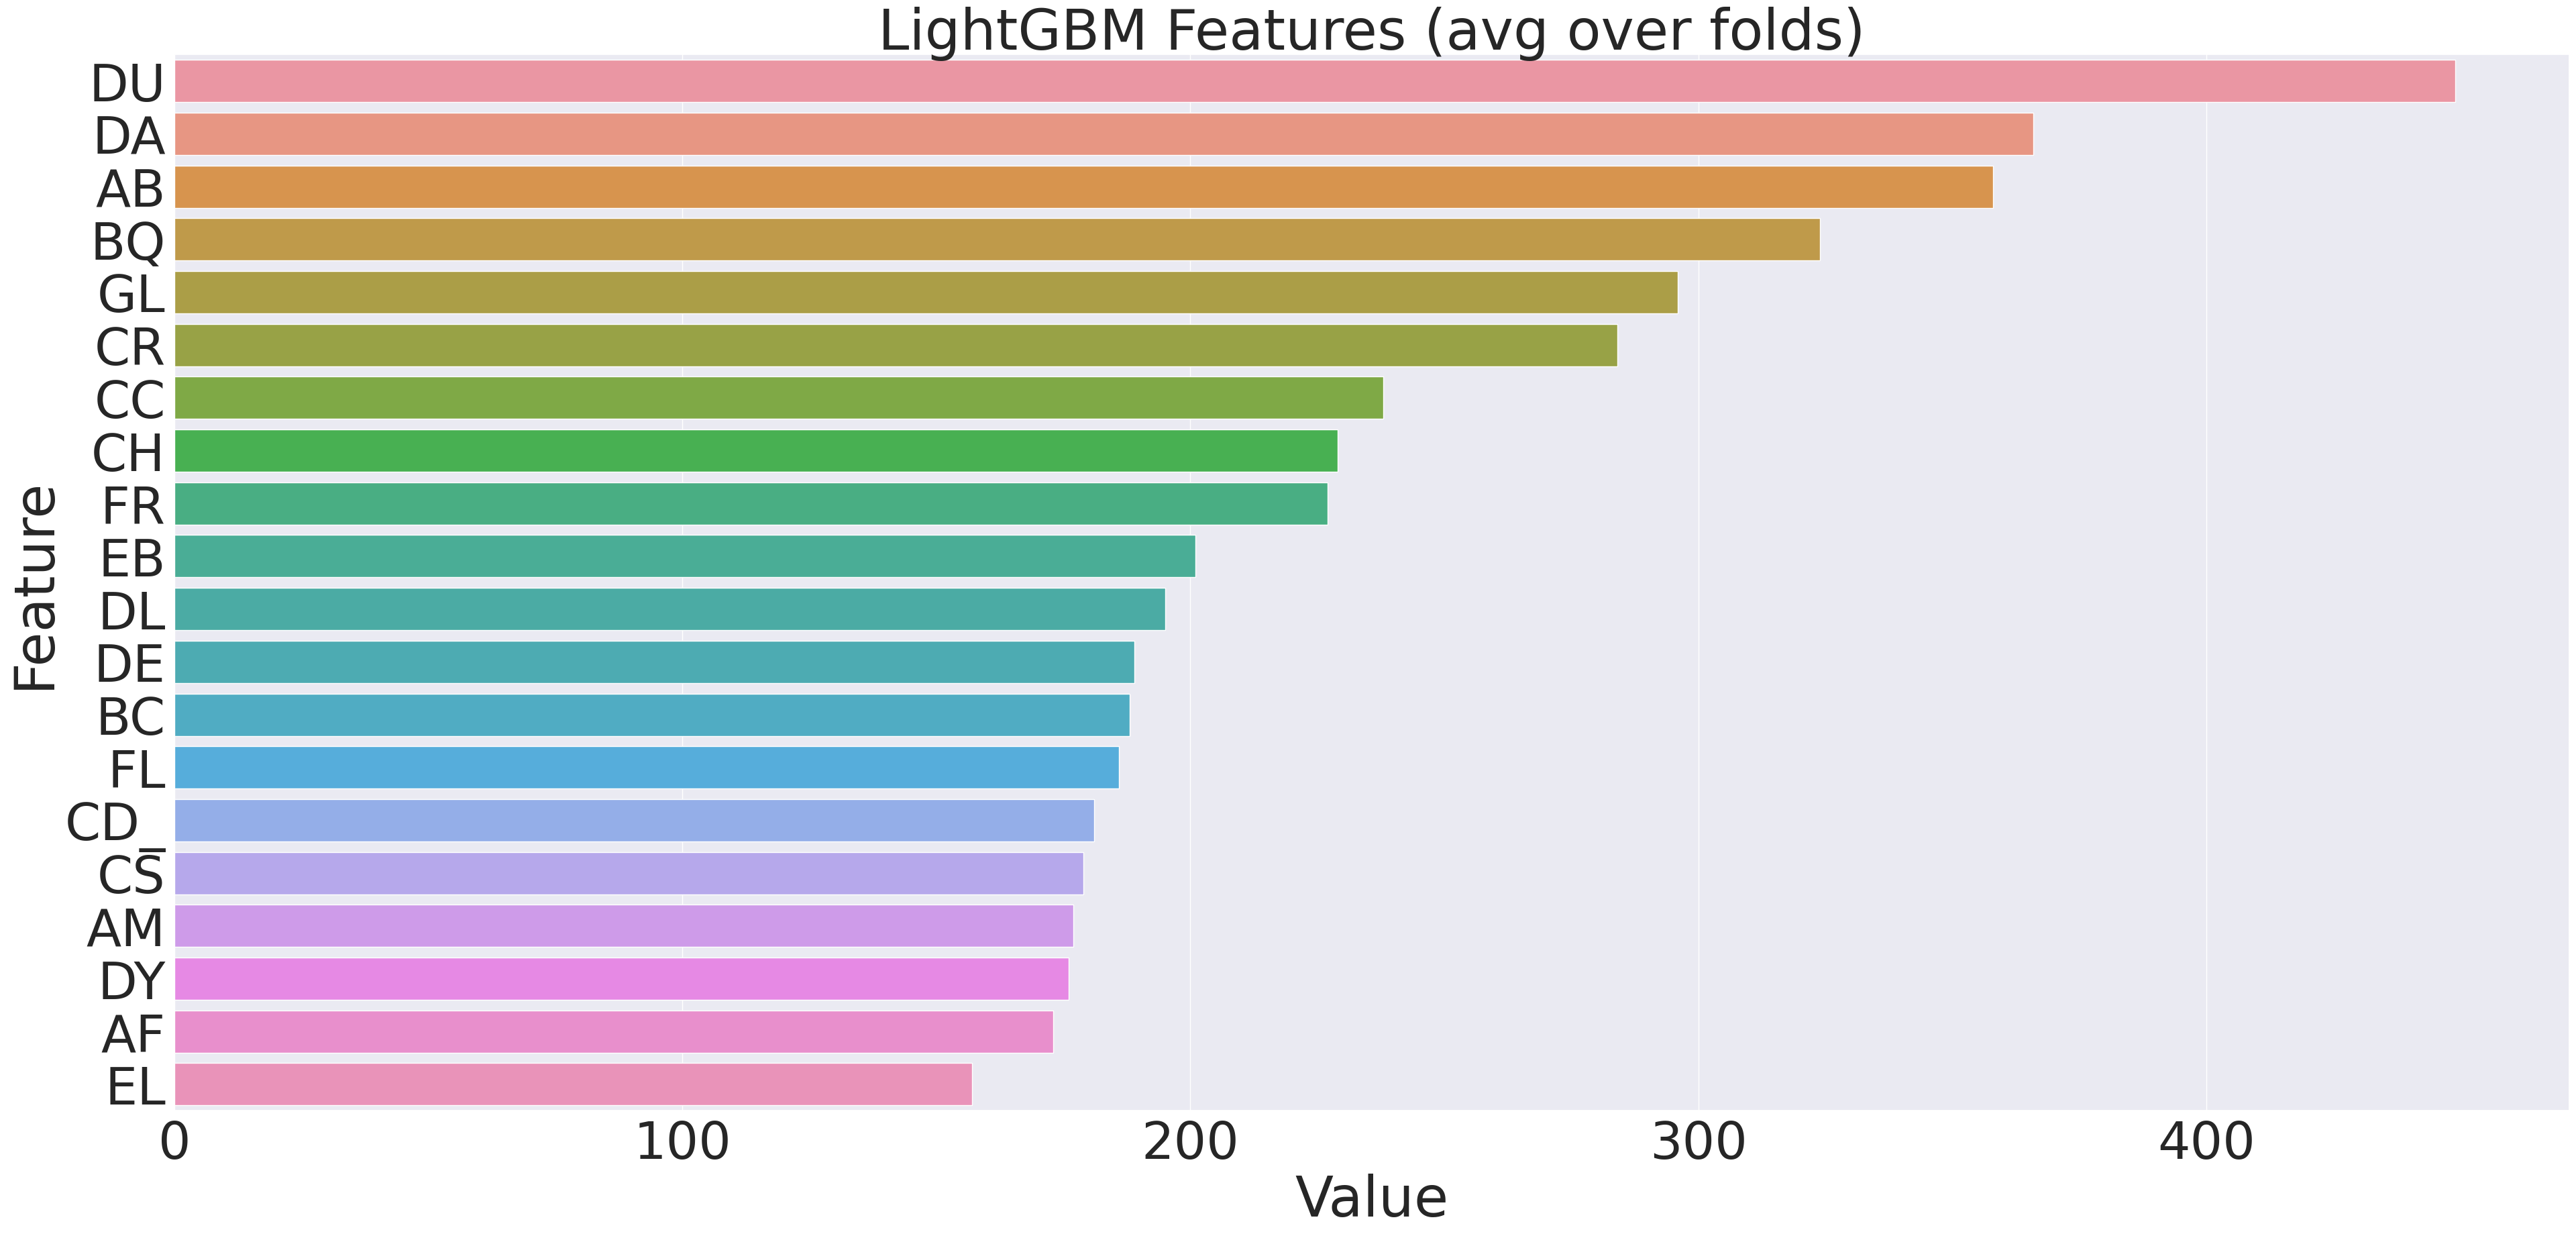

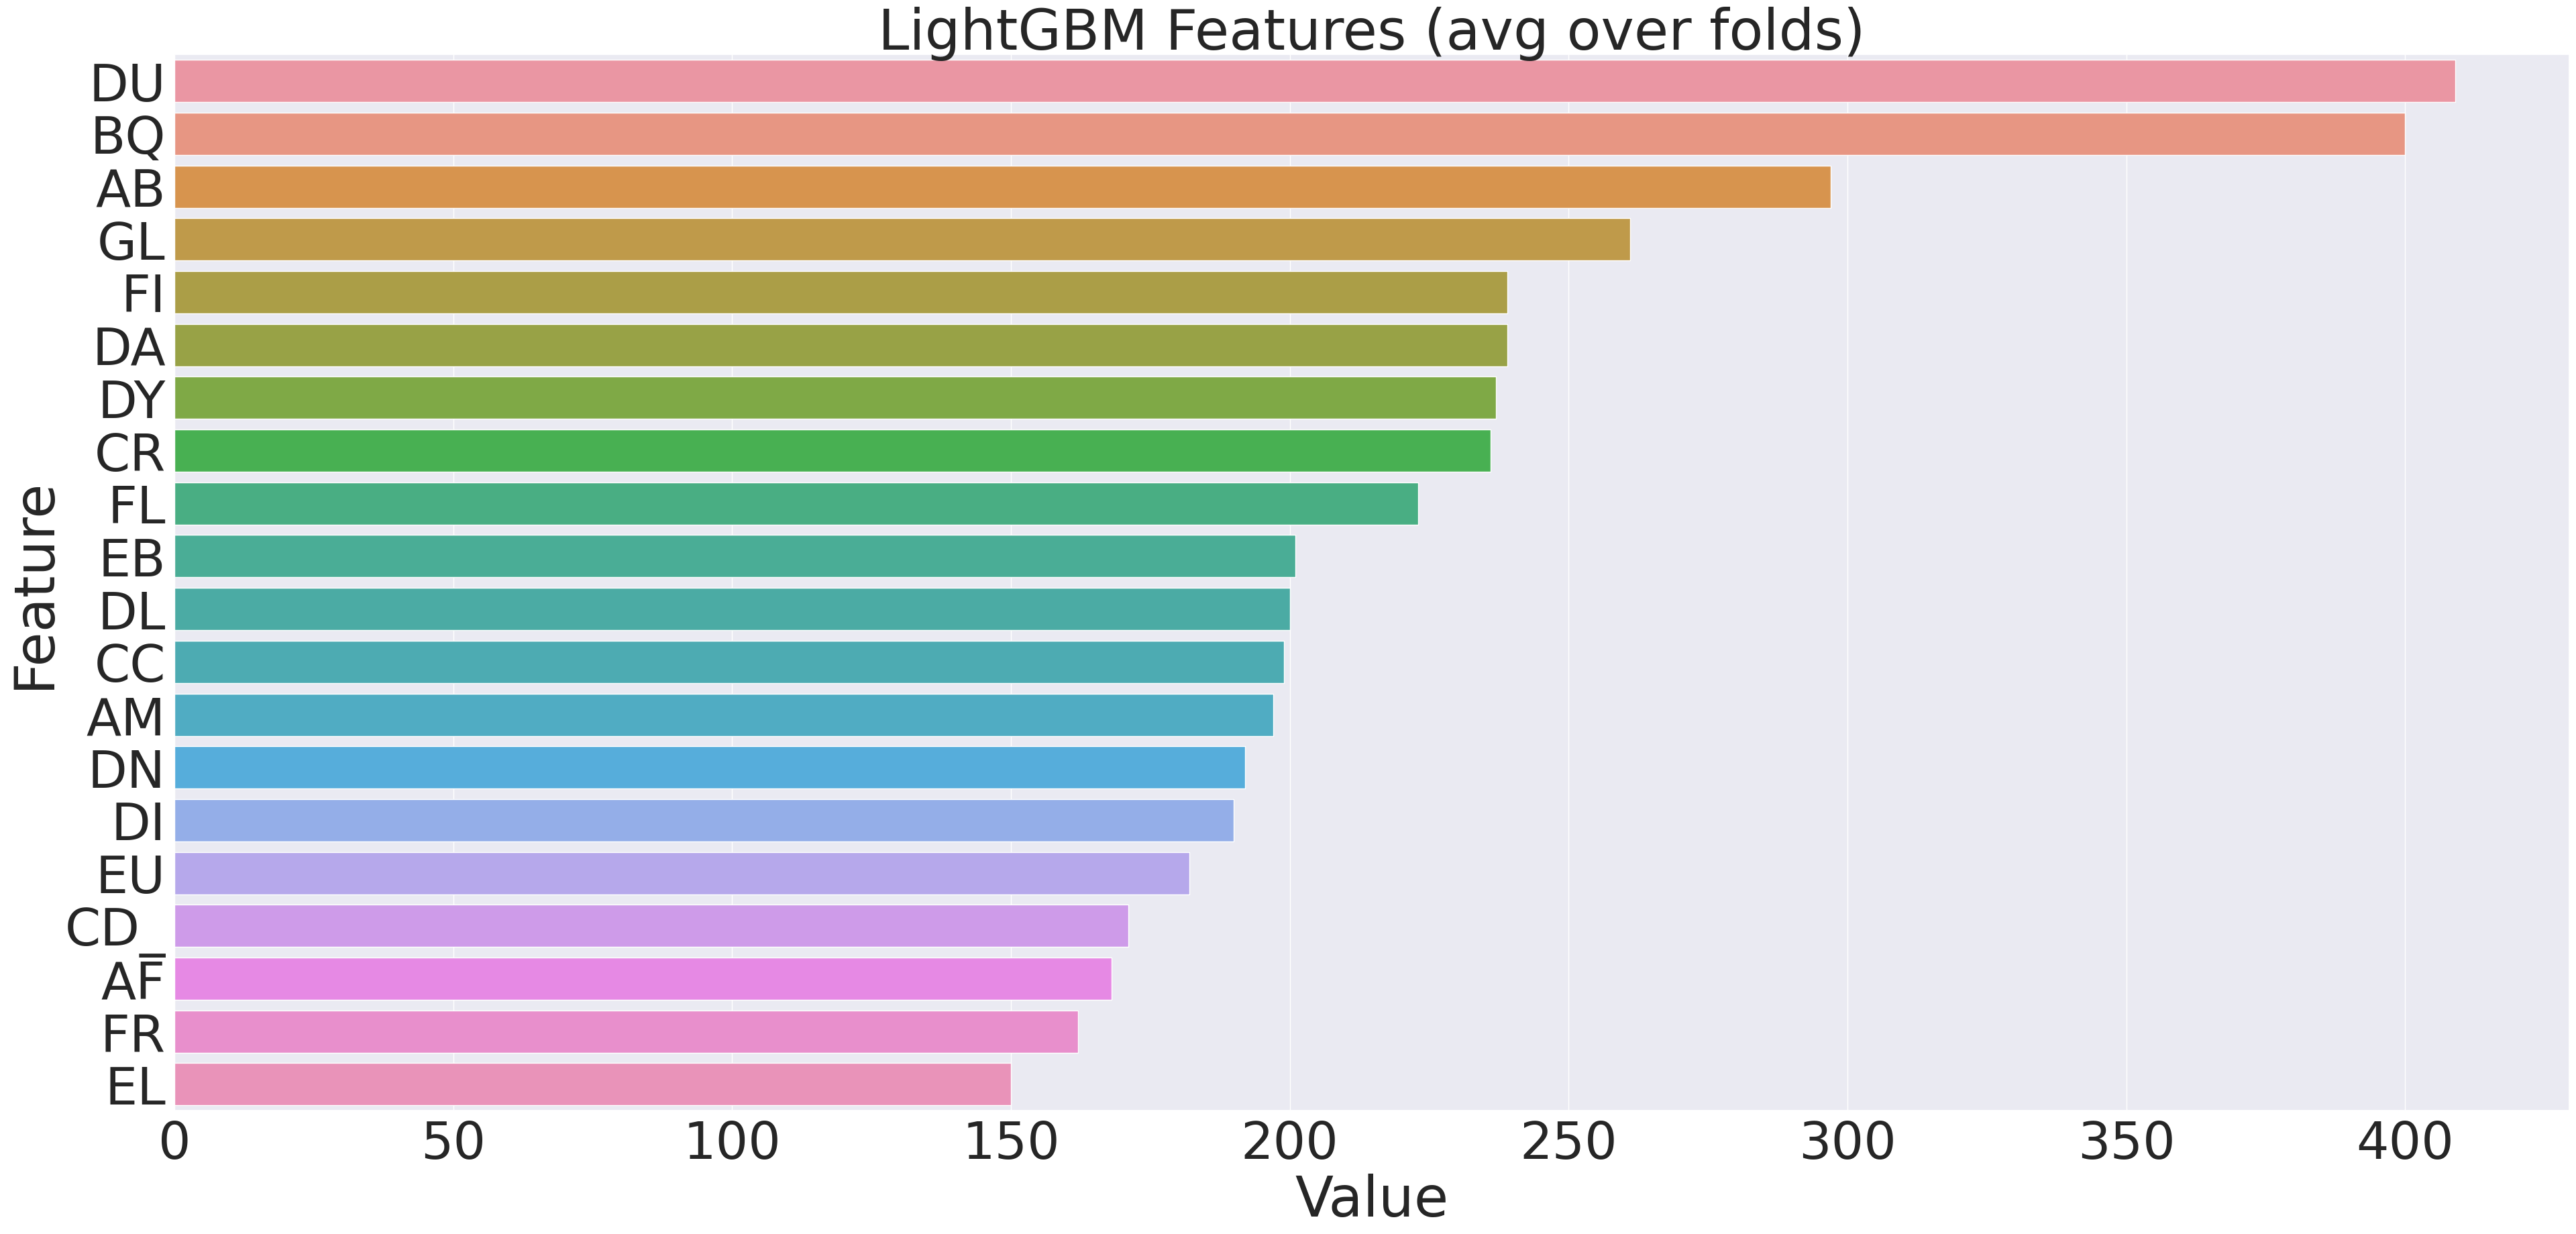

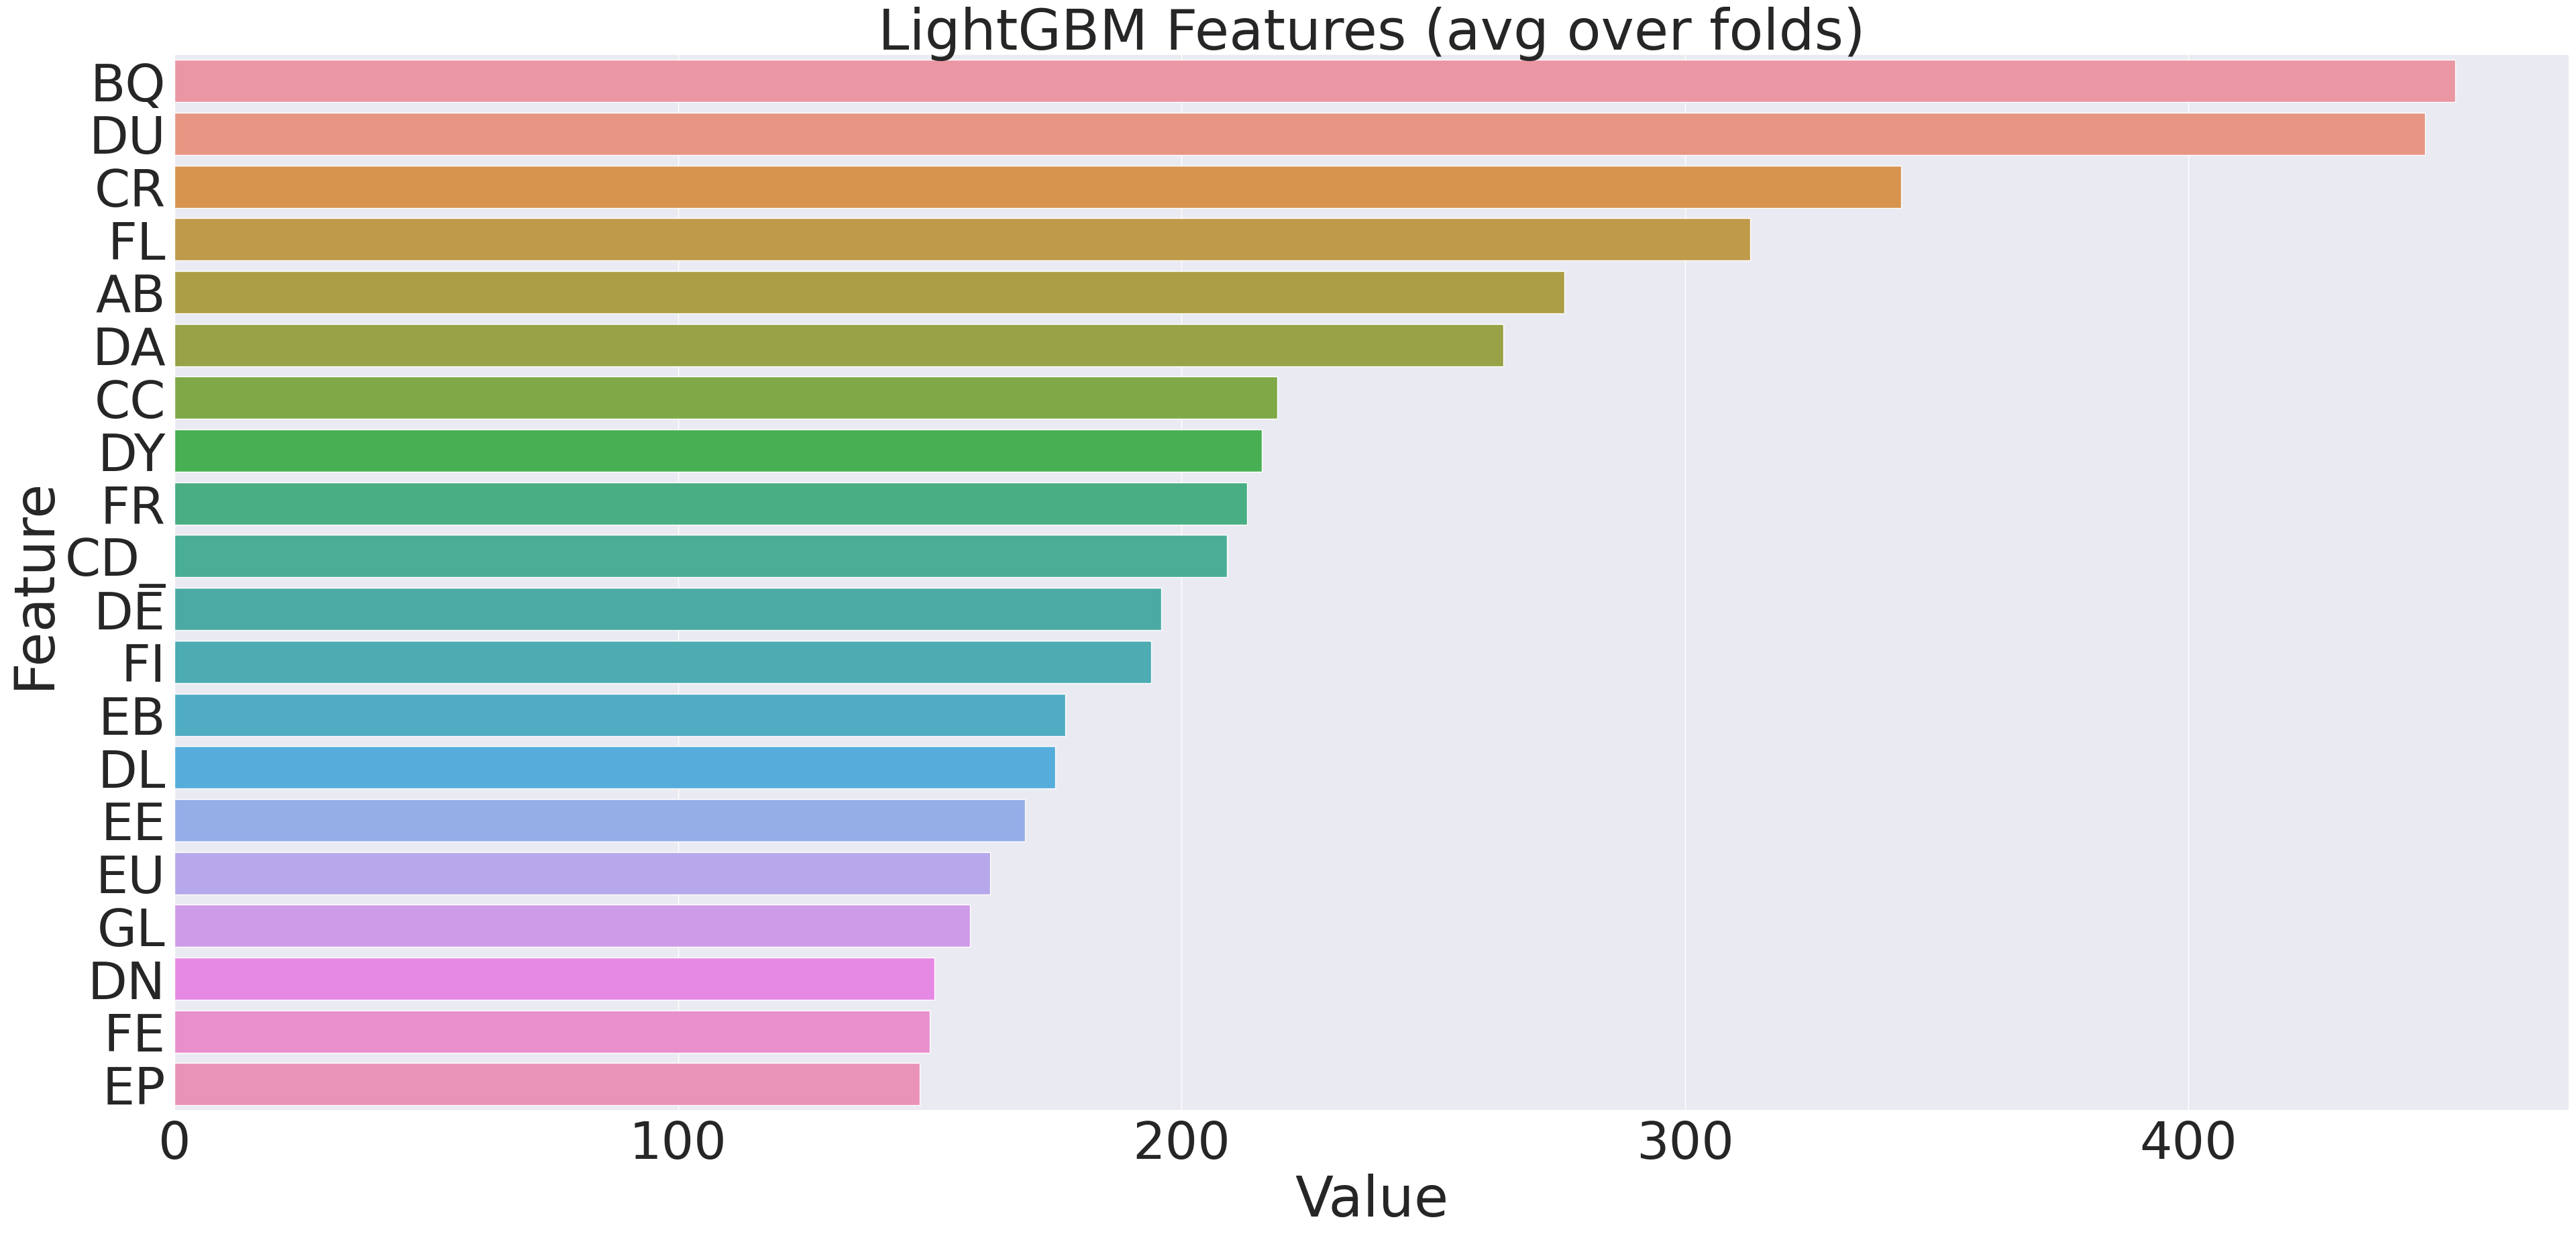

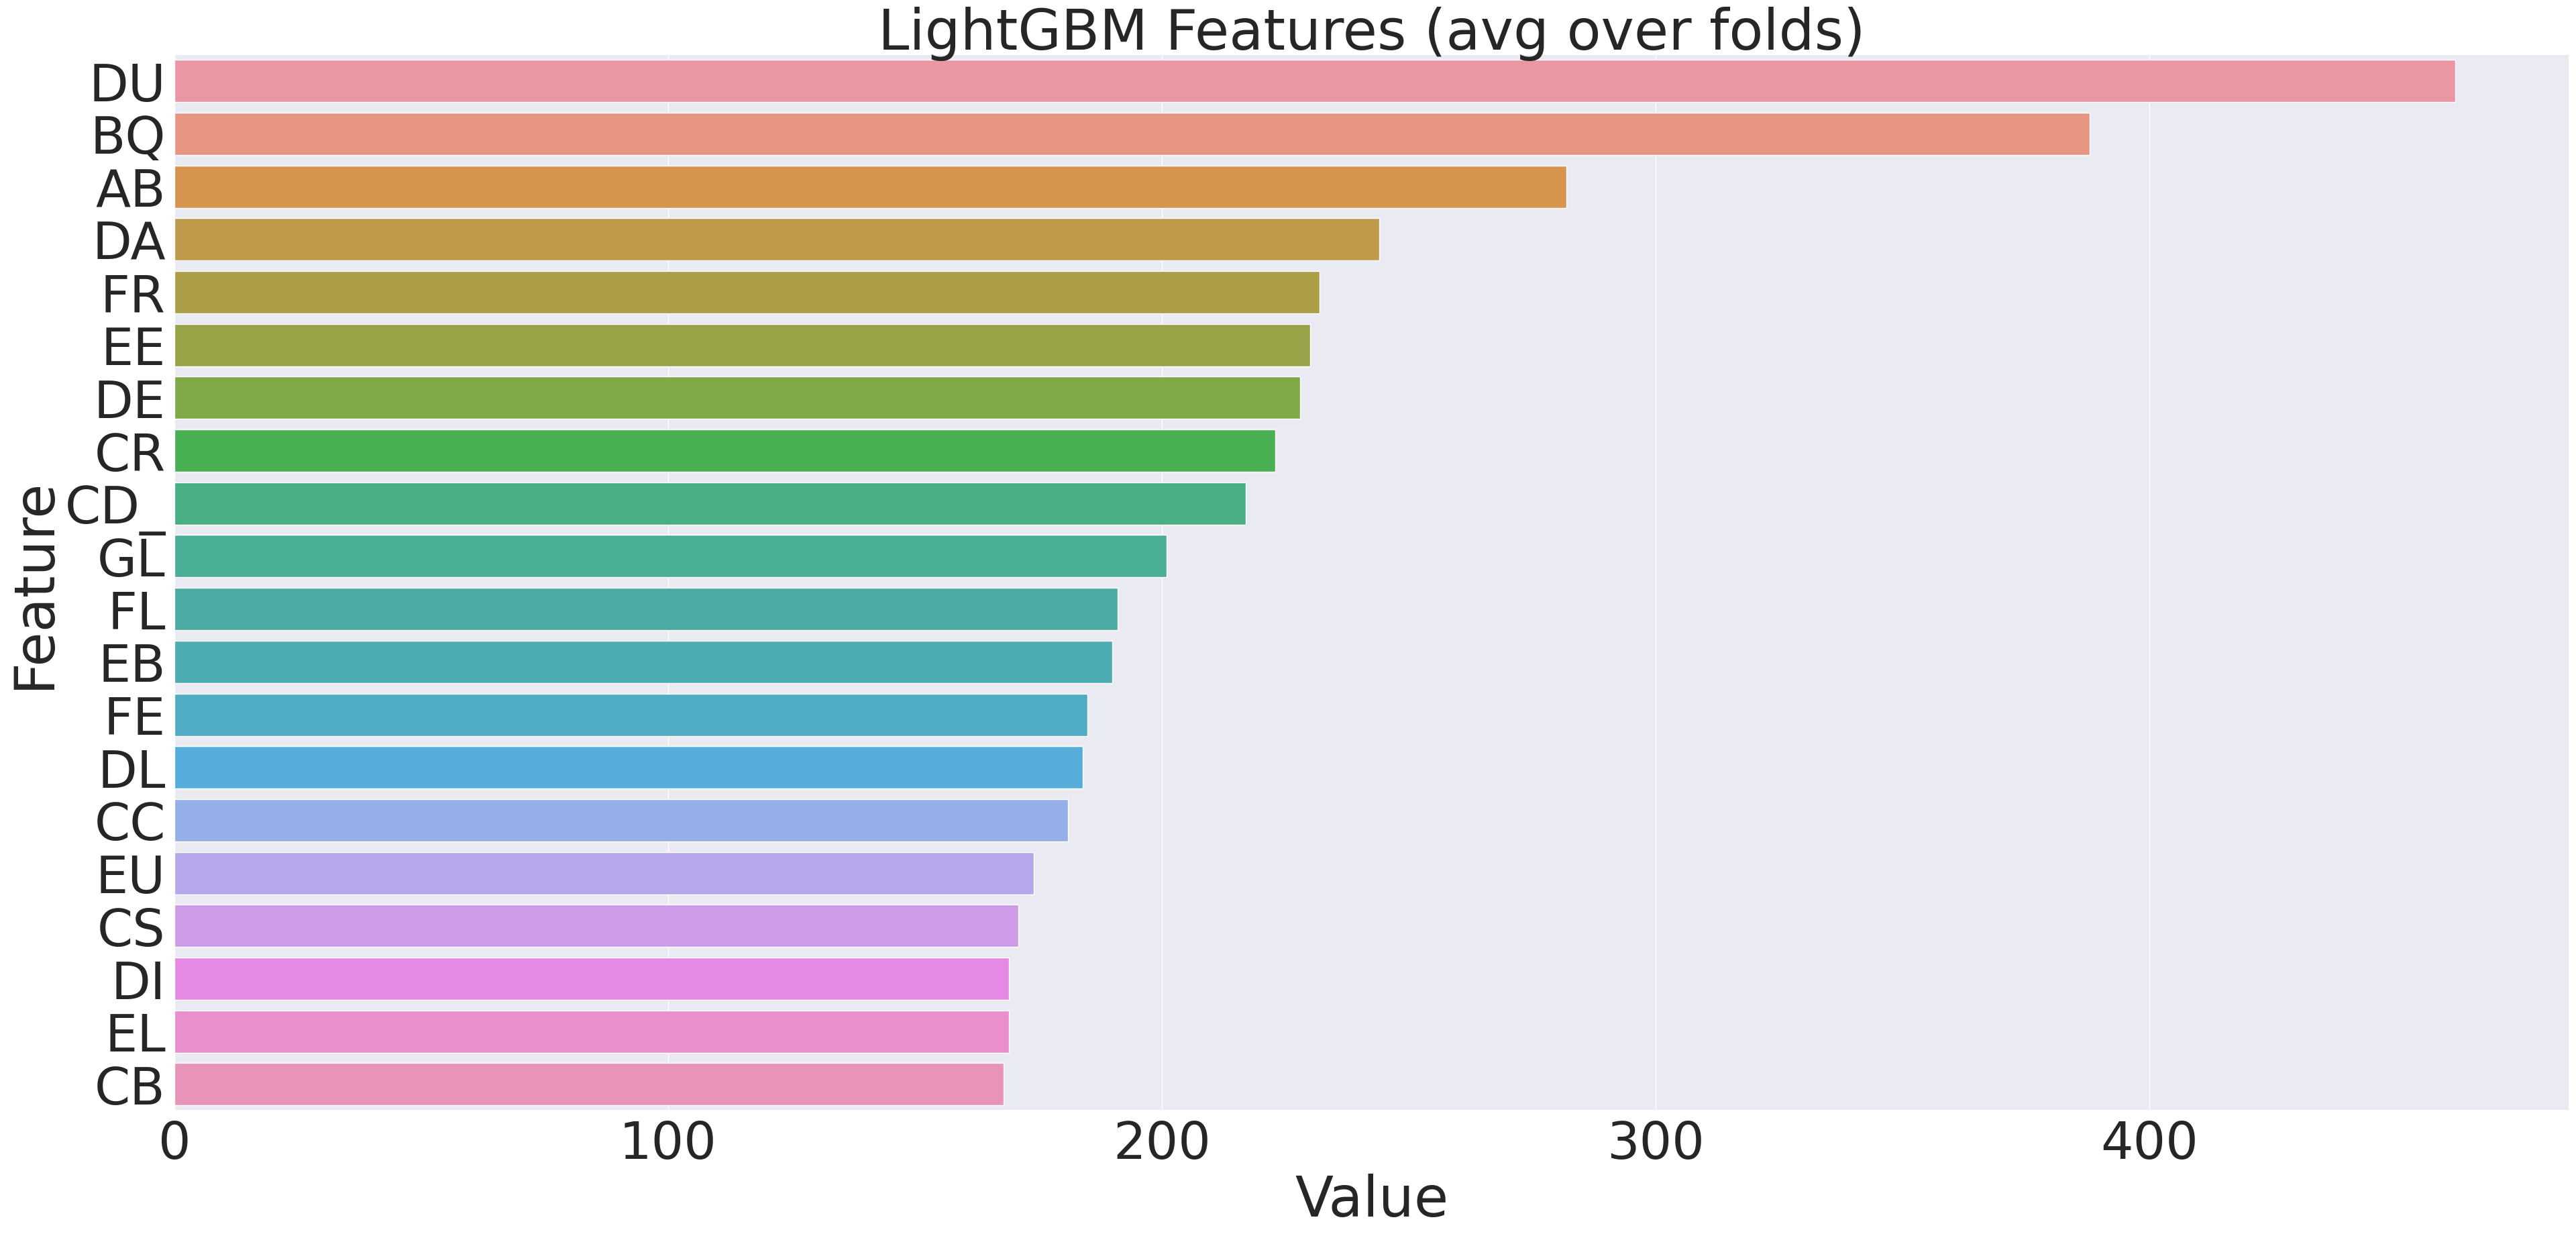

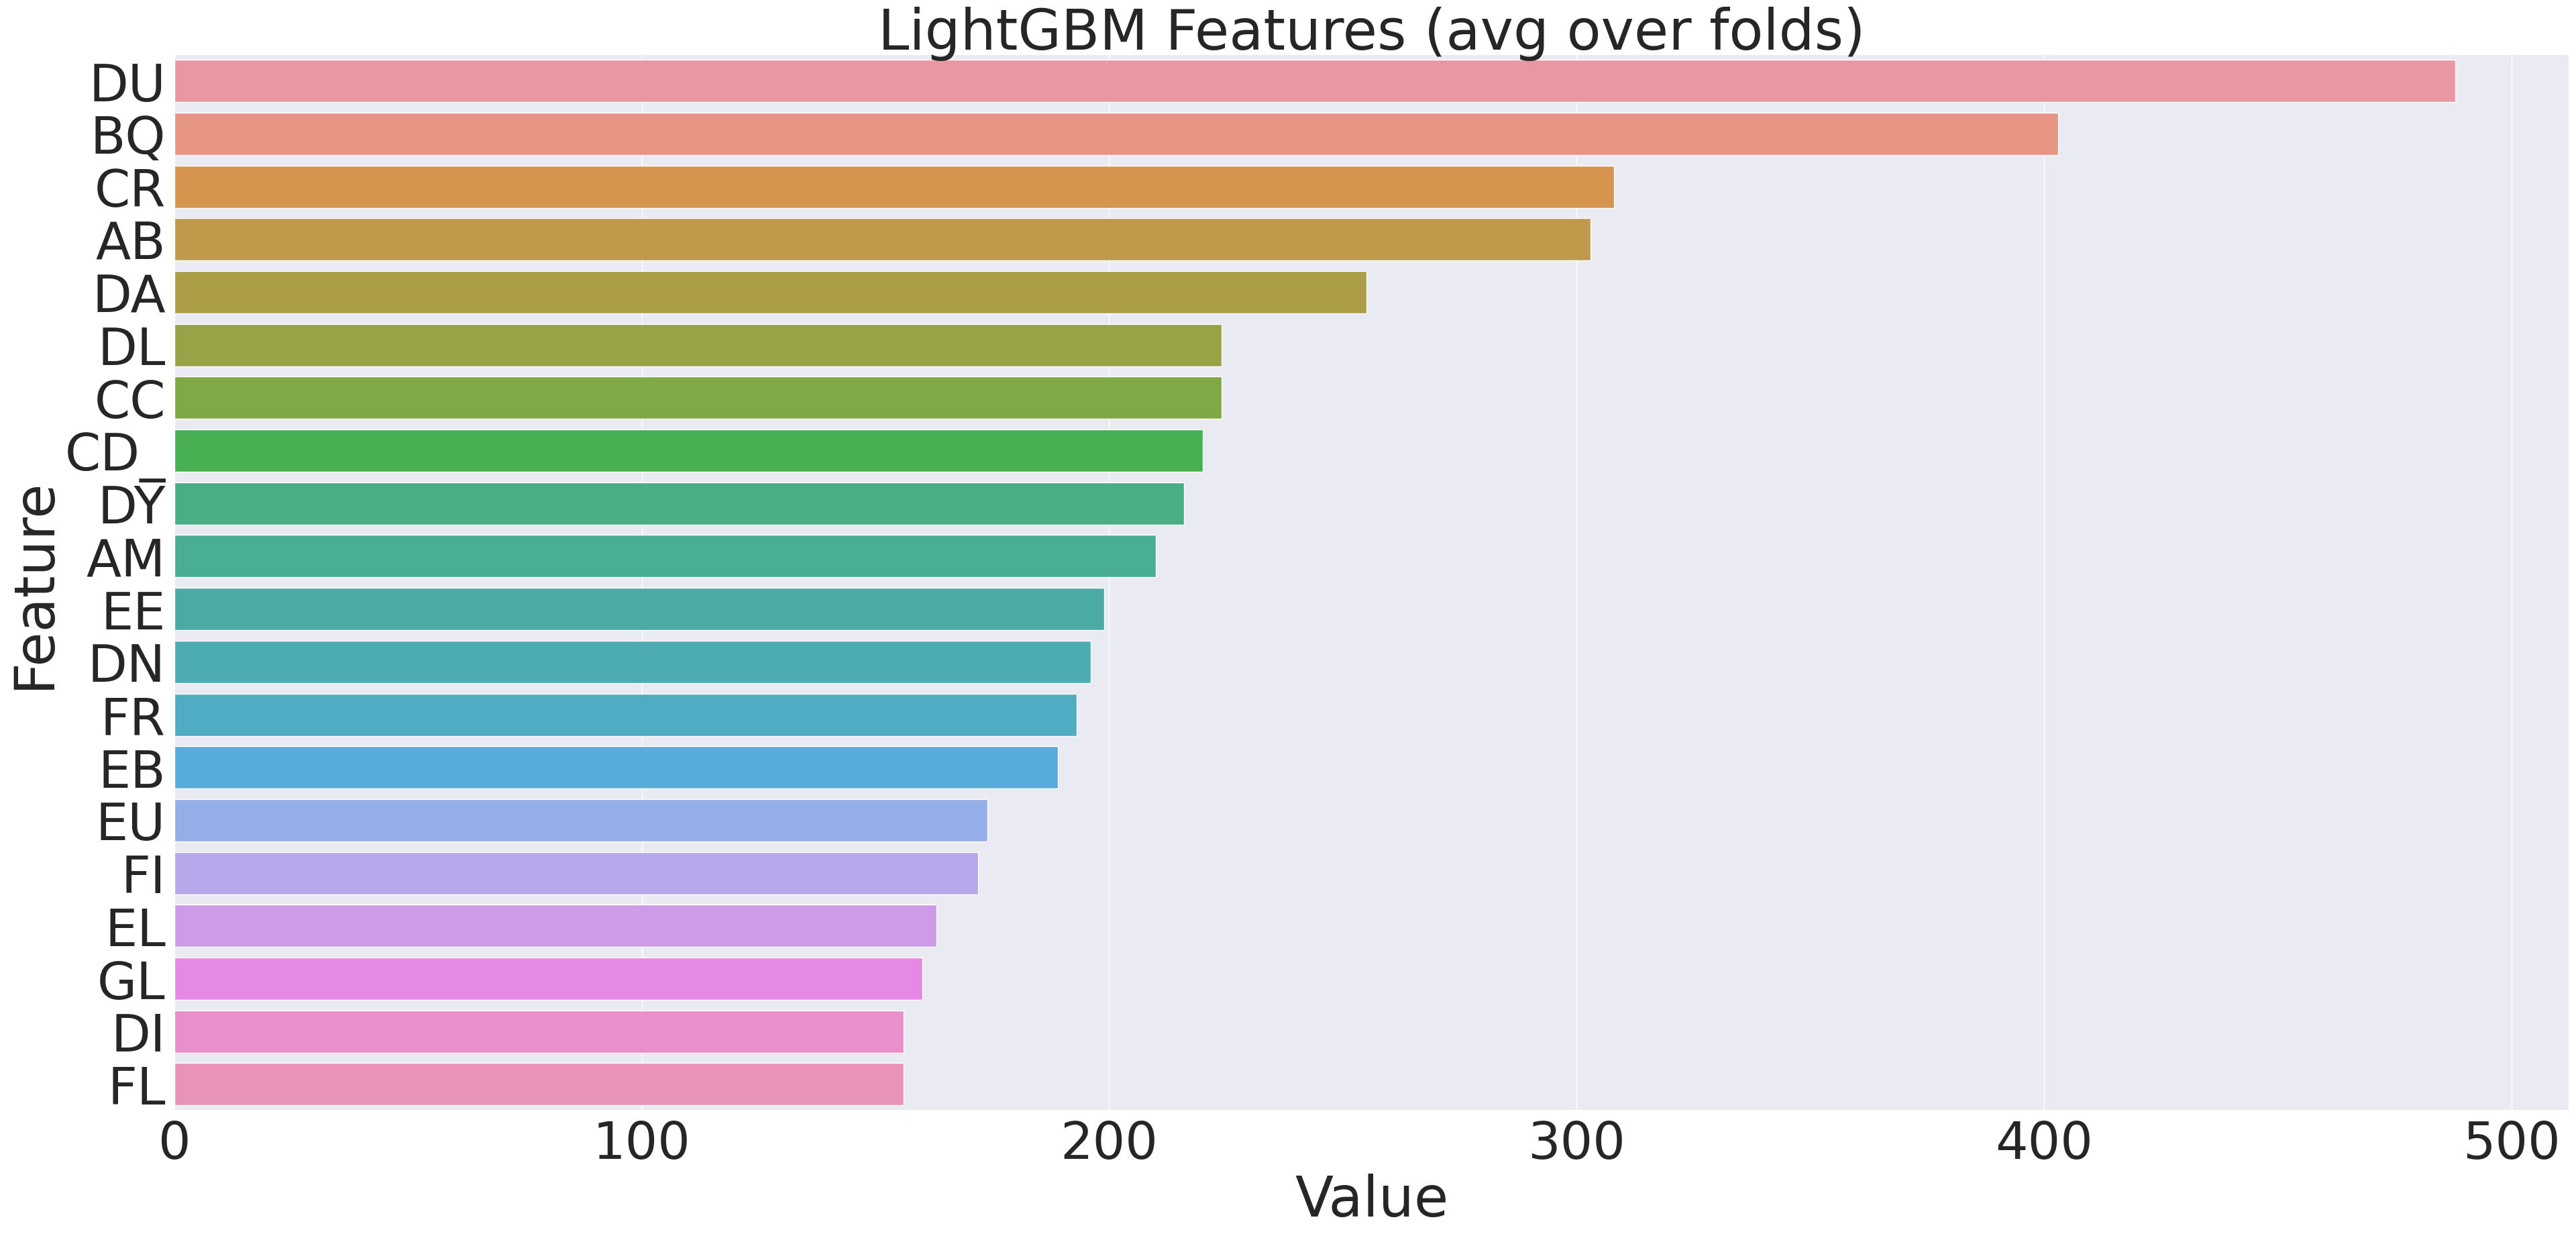

In [24]:
%%time


'''
{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.03,
'max_depth': 4, 'metric': 'binary_logloss', 'min_data_in_leaf': 20,
'n_estimators': 1000, 'num_leaves': 30, 'subsample': 0.5}

'''
if not config.do_grid:
    final_valid_predictions = {}
    final_test_predictions = []
    final_summ_predictions = []
    s  = []
    bs = []
    s_test = []
    bs_test = []

    for k in range(config.FOLDS):
        print('------------------ Fold: '+str(k))
        train     = df_train[df_train['kfold'] !=k].reset_index(drop=True)
        val       = df_train[df_train['kfold'] ==k].reset_index(drop=True)
        valid_ids = val.Id.values.tolist()

        X_train, y_train = train[features], train[label]
        X_valid, y_valid = val[features], val[label]

        model = LGBMClassifier(boosting_type='goss',learning_rate=0.01, n_estimators = 1000,  #  
                             early_stopping_round = 300, random_state=42,
                            subsample=0.7,
                            colsample_bytree=0.6,
                             class_weight='balanced',
                               min_data_in_leaf = 10,
                               num_leaves = 30,
                             metric=['binary_logloss'], is_unbalance=True, max_depth=4, seed = seed)
        
        model.fit(X_train, y_train, eval_set=(X_valid, y_valid), callbacks=[lgbm.log_evaluation(1000)]) #eval_metric=lgb_metric

    #     train_dataset = Pool(data=train[features], label=train[label], cat_features=["EJ"] )
    #     eval_dataset  = Pool(data=val[features], label=val[label], cat_features=["EJ"])
    #     params = {
    #        "iterations": 10000,
    #         "verbose": 1000,
    #         "learning_rate": 0.001,
    #         "depth": 4,
    #         'auto_class_weights':'Balanced',
    #         'loss_function':'MultiClass',
    #         'eval_metric':'MultiClass:use_weights=False',
    #     }
    #     model = CatBoostClassifier(**params)
    #     model.fit(train_dataset, eval_set=eval_dataset, use_best_model=True)

        print('TRAIN :', model.score(train[features], train[label]))
        print('VAL :', model.score(val[features], val[label]))

        preds_valid = model.predict_proba(val[features])
        if config.do_PCA:
            preds_summ = model.predict_proba(pca.transform(df_summit.iloc[:, 1:]))
        else:
            preds_summ  = model.predict_proba(df_summit[features])

        final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
        final_summ_predictions.append(preds_summ)

        # losses de val
        logloss  = log_loss(val[label], preds_valid)
        blogloss = config.balance_logloss(val[label], preds_valid) # balance
        s.append(logloss)
        bs.append(blogloss)

        print('Losses en val:')
        print(f'logloss {round(logloss, 2)} y balanced { round(blogloss, 2)}') 

        if config.do_TEST:
            print('TEST :', model.score(df_test[features], df_test[label]))
            preds_test  = model.predict_proba(df_test[features])
            final_test_predictions.append(preds_test)
            # losses de test
            logloss_test  = log_loss(df_test[label], preds_test)
            blogloss_test = config.balance_logloss(df_test[label], preds_test) # balance
            s_test.append(logloss_test)
            bs_test.append(blogloss_test)

            print('Losses en test:')
            print(f'logloss {round(logloss_test, 2)} y balanced { round(blogloss_test, 2)}') 
            
        plotImp(model, k)

    print('----------------------------------------------------')
    
    print('Log loss val:')
    print(f'Media {round(np.mean(s), 2)} y desviacion tipica { round(np.std(s), 2)}') 
    print('Balance Log loss:')
    print(f'Media {round(np.mean(bs), 2)} y desviacion tipica { round(np.std(bs), 2)}') 
    if config.do_TEST:
        print('----------------------------------------------------')
        print('Log loss test:')
        print(f'Media {round(np.mean(s_test), 2)} y desviacion tipica { round(np.std(s_test), 2)}')   
        print('Balance Log loss test:')
        print(f'Media {round(np.mean(bs_test), 2)} y desviacion tipica { round(np.std(bs_test), 2)}') 

In [25]:
'''
----------------------------------------------------
Log loss val:
Media 0.17 y desviacion tipica 0.05
Balance Log loss:
Media 0.29 y desviacion tipica 0.08
----------------------------------------------------
Log loss test:
Media 0.22 y desviacion tipica 0.03
Balance Log loss test:
Media 0.37 y desviacion tipica 0.07
CPU times: user 19.3 s, sys: 14.7 s, total: 34 s
Wall time: 29.6 s
'''

'\n----------------------------------------------------\nLog loss val:\nMedia 0.17 y desviacion tipica 0.05\nBalance Log loss:\nMedia 0.29 y desviacion tipica 0.08\n----------------------------------------------------\nLog loss test:\nMedia 0.22 y desviacion tipica 0.03\nBalance Log loss test:\nMedia 0.37 y desviacion tipica 0.07\nCPU times: user 19.3 s, sys: 14.7 s, total: 34 s\nWall time: 29.6 s\n'

In [26]:
'''
Generico
Log loss val:
Media 0.18 y desviacion tipica 0.07
Balance Log loss:
Media 0.38 y desviacion tipica 0.17
----------------------------------------------------
Log loss test:
Media 0.23 y desviacion tipica 0.06
Balance Log loss test:
Media 0.43 y desviacion tipica 0.16
CPU times: user 4.59 s, sys: 3.79 s, total: 8.37 s
Wall time: 7.17 s

'''

'''
quitando las dos
Log loss val:
Media 0.19 y desviacion tipica 0.06
Balance Log loss:
Media 0.41 y desviacion tipica 0.2
----------------------------------------------------
Log loss test:
Media 0.25 y desviacion tipica 0.06
Balance Log loss test:
Media 0.49 y desviacion tipica 0.15
CPU times: user 4.94 s, sys: 2.79 s, total: 7.73 s
Wall time: 5.23 s

'''

'''
CL
Log loss val:
Media 0.18 y desviacion tipica 0.06
Balance Log loss:
Media 0.38 y desviacion tipica 0.17
----------------------------------------------------
Log loss test:
Media 0.24 y desviacion tipica 0.08
Balance Log loss test:
Media 0.46 y desviacion tipica 0.23
CPU times: user 5.05 s, sys: 3 s, total: 8.05 s
Wall time: 5.71 s
'''

'''
BC
Log loss val:
Media 0.18 y desviacion tipica 0.07
Balance Log loss:
Media 0.45 y desviacion tipica 0.23
----------------------------------------------------
Log loss test:
Media 0.26 y desviacion tipica 0.06
Balance Log loss test:
Media 0.58 y desviacion tipica 0.11
CPU times: user 5.06 s, sys: 3.03 s, total: 8.08 s
Wall time: 4.93 s

'''

'\nBC\nLog loss val:\nMedia 0.18 y desviacion tipica 0.07\nBalance Log loss:\nMedia 0.45 y desviacion tipica 0.23\n----------------------------------------------------\nLog loss test:\nMedia 0.26 y desviacion tipica 0.06\nBalance Log loss test:\nMedia 0.58 y desviacion tipica 0.11\nCPU times: user 5.06 s, sys: 3.03 s, total: 8.08 s\nWall time: 4.93 s\n\n'

## SUBMISSION

In [27]:
def get_weigths(num_models, input_folds, names = None, verbose = 1):
    coeficientes = []
    for target in range(0, 2):
        print('Searching weigths for column ', target)
        # pillo las variables 
        cols_for_model = []
        for j in range(0, num_models):
            col = input_folds[j][:, target].tolist()
            # lo paso a 0's o 1's
    #         col = (col >= 0.5).astype(int)
            cols_for_model.append(col)
        # creo el modelo
        X = np.column_stack(cols_for_model)
        y = df_test[label].values
        # ---------añadido-------------
        X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.1, random_state=66)
        # --------------------------
        reg = GradientBoostingClassifier(n_estimators = 5000).fit(X_train, y_train)
        print('Score obtenido: ' + str(round(reg.score(X_test, y_test), 2)))
        reg_coef = reg.feature_importances_
        best_model_index = np.argmax(reg_coef)
        worst_model_index = np.argmin(reg_coef)
        if verbose == 1:
            print('El modelo con más peso es el fold ', best_model_index)
            print('El modelo con menos peso es el fold', worst_model_index)
            print(reg_coef)
            print(np.sum(reg_coef))
        coeficientes.append(reg_coef) # coef_
    #     coef_normalized = get_coeficients_normalized(reg_coef.ravel()) # solo en caso de no ser randomforest
#         save_csv(target, reg_coef, names)
        print('---------------------------------------------------------------------------')
        
    return coeficientes

In [28]:
# pesos en funcion del test
from sklearn.ensemble import GradientBoostingClassifier
if not config.do_grid:
    if config.ensemble == 'weigths':
        coef = get_weigths(len(final_test_predictions), final_test_predictions)
        print(coef)
        # aplicamos en la submmision
        final_test = np.zeros((len(final_summ_predictions[0]), 2))
        for i in range(0, len(final_summ_predictions)):
            sub = final_summ_predictions[i]
            coef_0 = coef[0][i]
            coef_1 = coef[1][i]
            final_test[:, 0] += sub[:, 0] * coef_0
            final_test[:, 1] += sub[:, 1] * coef_1

        print(final_test)
        print(final_test.shape)
    else:
        final_test = np.mean(final_summ_predictions, axis = 0)

Searching weigths for column  0
Score obtenido: 1.0
El modelo con más peso es el fold  1
El modelo con menos peso es el fold 2
[0.23504997 0.66048398 0.02688374 0.04374588 0.03383642]
0.9999999999999999
---------------------------------------------------------------------------
Searching weigths for column  1
Score obtenido: 1.0
El modelo con más peso es el fold  1
El modelo con menos peso es el fold 4
[0.22559734 0.67385472 0.03064797 0.04059924 0.02930074]
1.0
---------------------------------------------------------------------------
[array([0.23504997, 0.66048398, 0.02688374, 0.04374588, 0.03383642]), array([0.22559734, 0.67385472, 0.03064797, 0.04059924, 0.02930074])]
[[0.59295594 0.40316624]
 [0.59295594 0.40316624]
 [0.59295594 0.40316624]
 [0.59295594 0.40316624]
 [0.59295594 0.40316624]]
(5, 2)


In [29]:
if not config.do_grid:
#     final_test = (final_summ_predictions[0] + final_summ_predictions[1] + final_summ_predictions[2] + final_summ_predictions[3] + final_summ_predictions[5])/5
    test_dict = {}
    test_dict.update(dict(zip(df_summit.Id.values.tolist(), final_test)))
    submission = pd.DataFrame.from_dict(test_dict, orient="index").reset_index()
    submission.columns = ['Id', 'class_0', 'class_1']                       

    submission.to_csv(r"submission.csv", index=False)

In [30]:
submission

,Id,class_0,class_1
0,00eed32682bb,0.592956,0.403166
1,010ebe33f668,0.592956,0.403166
2,02fa521e1838,0.592956,0.403166
3,040e15f562a2,0.592956,0.403166
4,046e85c7cc7f,0.592956,0.403166


In [31]:
if not config.do_grid:
    df_final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
    df_final_valid_predictions.columns = ['Id', 'class_0', 'class_1']
    df_final_valid_predictions.to_csv(r"oof.csv", index=False)

    #Befor checking accuracy let's first make sure that we have the data are sorted in the same way :)
    df_final_valid_predictions   = df_final_valid_predictions.sort_values('Id')
    Train                     = df_train.sort_values('Id')

    print('logarithmic loss for the baseline: '+str(log_loss(Train['Class'], df_final_valid_predictions[['class_0', 'class_1']].values)))
    print('balanced logarithmic loss for the baseline: '+str(config.balance_logloss(Train['Class'], df_final_valid_predictions[['class_0', 'class_1']].values)))

logarithmic loss for the baseline: 0.16398523175749055
balanced logarithmic loss for the baseline: 0.2690619386414356
